In [12]:
import numpy as np
from numpy import *
import astropy.units as u
import astropy.constants as c
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import isochrones as iso
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import filtermatch as fm

In [2]:
stars = fits.open('unions_ugriz_stars.fits')
stars_arr = stars[0].data
stars_data = stars[1].data
stars_header = stars[1].header
#stars_df = pd.DataFrame(stars_data)

In [3]:
stars_header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                   80 / width of table in bytes                        
NAXIS2  =             19086037 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   14 / number of columns                              
EXTNAME = '/Users/mcconnacha/Research1/CFIS/MBCAT/temp.csv' / table name        
TTYPE1  = 'RA      '           / label for column 1                             
TFORM1  = 'D       '           / format for column 1                            
TTYPE2  = 'Dec     '           / label for column 2                             
TFORM2  = 'D       '        

In [4]:
cfis_id = stars_data['CFIS_ID']
ra = stars_data['RA']
dec = stars_data['Dec']
uband = stars_data['CFIS_U_MAG_AUTO']
uerr = stars_data['CFIS_U_MAGERR_AUTO']
gband = stars_data['HSC_G_MAG_AUTO']
gerr = stars_data['HSC_G_MAGERR_AUTO']
rband = stars_data['CFIS_R_MAG_AUTO']
rerr = stars_data['CFIS_R_MAGERR_AUTO']
iband = stars_data['PS_i_stk_kron']
ierr = stars_data['PS_i_stk_kron_err']
zband = stars_data['PS_z_stk_kron']
zerr = stars_data['PS_z_stk_kron_err']
stargal = stars_data['CFIS_R_StarGal']

In [65]:
def cut(idxs):
    """
    For any array of boolean values which indicate desirable indicies, 
    select those data points from all sets and return as a full array of sets
    """
       
    indicies = idxs*np.arange(1, len(idxs)+1)
    ids = indicies[indicies!=0]-1
    
    return np.array([cfis_id[ids], ra[ids], dec[ids], uband[ids], uerr[ids], gband[ids], gerr[ids],
                     rband[ids], rerr[ids], iband[ids], ierr[ids], zband[ids], zerr[ids], stargal[ids]])

def spec_cut(idxs, props):
    """
    For any array of boolean values which indicate desirable indicies, 
    select those data points from all sets and return as a full array of sets
    """
       
    indicies = idxs*np.arange(1, len(idxs)+1)
    ids = indicies[indicies!=0]-1
    
    returns = []
    for i in props:
        returns.append(i[ids])
    returns=np.array(returns)
    
    return returns
    

def radec_cut(ra_low, ra_high, dec_low, dec_high):
    """
    Return indexes of all data points meeting this criteria in RA and Dec
    """
    
    ra_gtr = ra > ra_low
    ra_lsr = ra < ra_high    
    dec_gtr = dec > dec_low
    dec_lsr = dec < dec_high
    
    tot_range = ra_gtr*ra_lsr*dec_gtr*dec_lsr
    
    return tot_range

def iso_cut(col_low, col_high, col, mag_low, mag_high, mag):
    """
    Return indexes of all data points meeting this criteria in a specified Color and Mag
    """
    
    col_gtr = col > col_low
    col_lsr = col < col_high    
    mag_gtr = mag > mag_low
    mag_lsr = mag < mag_high
    
    tot_range = col_gtr*col_lsr*mag_gtr*mag_lsr
    
    return tot_range

def mag_or_err_cut(mag_low, mag_high, band_or_err):
    """
    Return indexes of all data points meeting this criteria for either a specified passband or passband error
    """
    
    mag_gtr = band_or_err > mag_low
    mag_lsr = band_or_err < mag_high    
    
    tot_range = mag_gtr*mag_lsr
    
    return tot_range

In [6]:
import matplotlib.patches as patches

In [7]:
zone_511 = cut(radec_cut(135, 150, 30, 37))

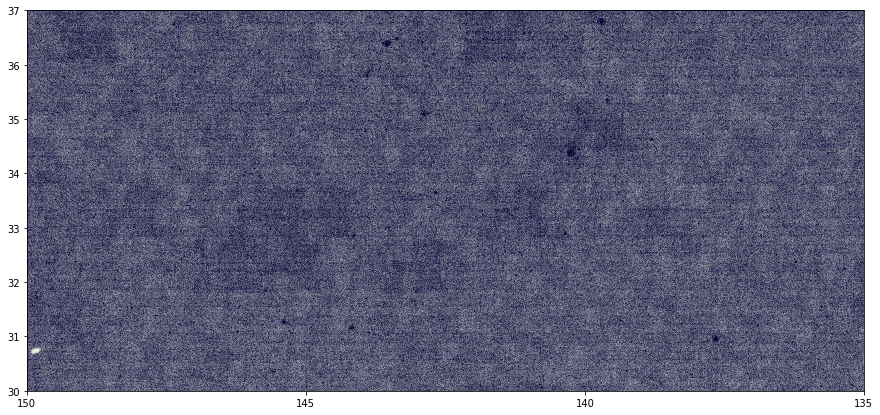

In [9]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(zone_511[1], zone_511[2], s=0.00032, color=(1, 1, 0.95))
#rect = patches.Rectangle((-100, 100), 10000, 10000, linewidth=10, edgecolor='r', facecolor='r')
#ax.add_patch(rect)

ax.set_facecolor((0, 0, 0.2))

ax.set_xlim([150, 135])
ax.set_ylim([30, 37])

ax.set_xticks([150, 145, 140, 135])


plt.show()

In [9]:
LeoA = cut(radec_cut(149.75, 150, 30.66, 30.83))

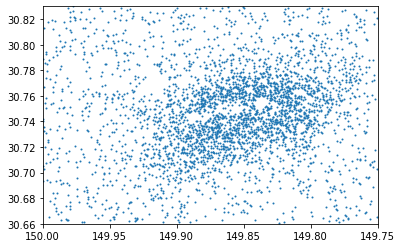

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

sc = ax.scatter(LeoA[1], LeoA[2], s=1)

plt.xlim([150, 149.75])
plt.ylim([30.66, 30.83])
plt.show()

In [46]:
import matplotlib.patches as patches

In [7]:
all_header, all_data = iso.open_create('1-13_02-0.dat')

In [13]:
gmag = all_data[3][:-5, 29]
rmag = all_data[3][:-5, 30]

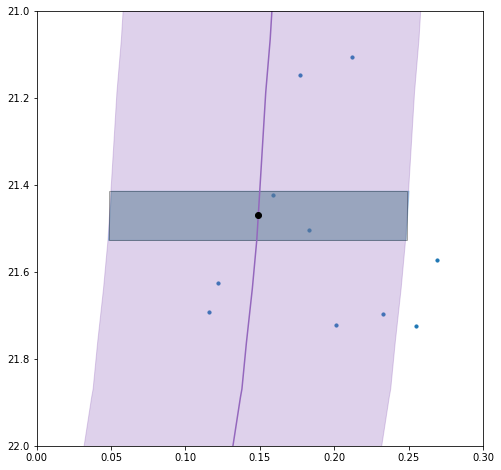

In [64]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

d = 9
a = 13*d

test_iso = all_data[2+(9)*13]

umag = np.array(test_iso[:, 28])
gmag = np.array(test_iso[:, 29])
rmag = np.array(test_iso[:, 31])
imag = np.array(test_iso[:, 30])
zmag = np.array(test_iso[:, 32])
test_iso[0, 1], np.round(10**test_iso[0, 2]/10**9)

cut, diff = fm.find_jump(rmag, imag)
color = (rmag-imag)[:cut]
mag = imag[:cut]


dist = 80
sc = ax.scatter(x = LeoA[5]-LeoA[7], y = LeoA[7], s=10)
ax.plot(color, mag+iso.dist_mod(dist), color='tab:purple')
ax.fill_betweenx(mag+iso.dist_mod(dist), color-0.1, color+0.1, color='tab:purple', alpha=0.3)

sec = 59

ax.fill_betweenx(mag[sec:sec+2]+iso.dist_mod(dist), color[sec:sec+2]-0.1, color[sec:sec+2]+0.1, color='tab:blue', alpha=0.3)
x_coord = (color[sec]+color[sec+1])/2 - width/2
y_coord = (mag[sec]+mag[sec+1])/2+iso.dist_mod(dist) - height/2
width = 0.1+0.1
height = np.abs(mag[sec]-mag[sec+1])
plt.plot(x_coord+width/2, y_coord+height/2, 'ko')
rect = patches.Rectangle((x_coord, y_coord), width, height, linewidth=1, edgecolor='black', facecolor='grey', alpha=0.3)
ax.add_patch(rect)

#plt.colorbar(sc)
ax.set_xlim([-2.5, 2.5])
ax.set_xlim([0, 0.3])

ax.set_ylim([15, 27])
ax.set_ylim([21, 22])
#ax.set_facecolor((0.7, 0.7, 0.7))
plt.gca().invert_yaxis()

plt.show()

this approx as rectangles method also gives a pretty nice way to estimate error, compare rectangle coverage to actual area coverage by the curve. though I have to compute that curve. integral? I could maybe even make that exact shape, but it would be more work and I expect this rectangle approximation will do an excellent job of it all

In [71]:
iso_cut(x_coord, x_coord+width, color, y_coord+height, y_coord, mag)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [15]:
Tri_sq = cut(radec_cut(ra_low=22.85, dec_low=30.00, ra_high=24.120, dec_high=31.365))

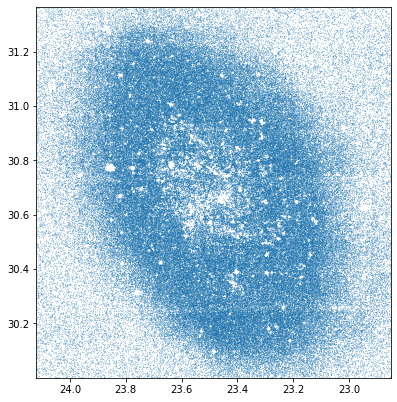

In [17]:
wid = 24.120 - 22.85
hei = 31.365 - 30

ra_min = np.min(Tri_sq[1])
ra_max = np.max(Tri_sq[1])
dec_min = np.min(Tri_sq[2])
dec_max = np.max(Tri_sq[2])


plt.figure(figsize=(wid*5, hei*5))

plt.scatter(Tri_sq[1], Tri_sq[2], s=0.01)
plt.xlim([ra_max, ra_min])
plt.ylim([dec_min, dec_max])
plt.show()

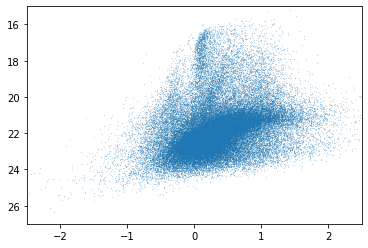

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

sc = ax.scatter(x = Tri_sq[7]-Tri_sq[9], y = Tri_sq[9], s=0.01, vmin=-2.5, vmax=2.5)
#plt.colorbar(sc)
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([27, 15])
#ax.set_facecolor((0.6, 0.6, 0.6))

plt.show()

In [6]:
def ra_convert(ra):
    """
    Convert HH:MM:SS RA into decimal degrees
    ra - str
    """
    ra_i = ra.split(':')
    return float(ra_i[0])*15+float(ra_i[1])*15/60+float(ra_i[2])*15/3600 

In [8]:
ra_convert('8:00:00')

120.0

In [18]:
gal = fits.open('NearbyGalaxies.fits')
gal_df = pd.DataFrame(gal[1].data)

In [55]:
ra_gal, dec_gal = np.array(gal_df['RA']), np.array(gal_df['Dec'])

In [56]:
dec_gal

array(['26:48:0.0  ', '-27:40:0.0 ', '-17:25:12.0', '-28:1:48.0 ',
       '64:33:55.0 ', '-52:17:1.0 ', '-50:9:48.0 ', '-46:26:24.0',
       '-54:7:8.0  ', '-50:1:5.0  ', '3:36:0.0   ', '-51:9:56.0 ',
       '-46:9:36.0 ', '5:25:12.0  ', '-54:24:22.0', '-50:16:59.0',
       '-54:2:57.0 ', '-60:27:0.0 ', '-22:4:5.0  ', '36:10:42.0 ',
       '-59:36:0.0 ', '-60:51:0.0 ', '-63:16:12.0', '38:2:28.0  ',
       '33:25:9.0  ', '36:29:52.0 ', '43:11:45.0 ', '47:37:41.0 ',
       '24:34:57.0 ', '50:40:33.0 ', '44:48:16.0 ', '33:48:5.0  ',
       '34:22:29.0 ', '33:0:16.0  ', '29:41:49.0 ', '35:2:37.0  ',
       '38:7:3.0   ', '32:22:36.0 ', '44:19:20.0 ', '45:5:20.0  ',
       '35:7:56.0  ', '42:28:15.0 ', '28:5:25.0  ', '38:43:8.0  ',
       '46:21:58.0 ', '30:45:20.0 ', '46:51:7.0  ', '47:54:58.0 ',
       '45:23:13.0 ', '31:12:58.0 ', '49:38:48.0 ', '41:17:28.0 ',
       '51:33:35.0 ', '40:59:18.0 ', '-27:19:52.0', '-36:46:2.0 ',
       '-25:59:24.0', '-12:50:53.0', '-9:19:39.0 ', '14:30:0.0

In [45]:
ra_i = ra[0].split(':')
float(ra_i[0])*15+float(ra_i[1])*15/60+float(ra_i[2])*15/3600

209.3

### Band Depth Approximations

In [6]:
valid_u = cut(mag_or_err_cut(0, 30, uband))
new_u = valid_u[3]
new_u_err = valid_u[4]

valid_g = cut(mag_or_err_cut(0, 30, gband))
new_g = valid_g[5]
new_g_err = valid_g[6]

valid_r = cut(mag_or_err_cut(0, 30, rband))
new_r = valid_r[7]
new_r_err = valid_r[8]

valid_i = cut(mag_or_err_cut(0, 30, iband)*mag_or_err_cut(-10, 200, ierr))
new_i = valid_i[9]
new_i_err = valid_i[10]

valid_z = cut(mag_or_err_cut(0, 30, zband)*mag_or_err_cut(-10, 200, zerr))
new_z = valid_z[11]
new_z_err = valid_z[12]

In [7]:
len(new_u), len(new_g), len(new_r), len(new_i), len(new_z)

(3721748, 5421243, 19086037, 6434403, 5297830)

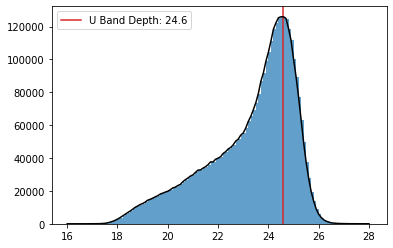

In [8]:
count = plt.hist(new_u, bins=np.arange(16, 28.1, 0.1), alpha=0.7, color='tab:blue')
bins = count[1][:-1]
curve = count[0]
peaks = find_peaks(curve,height=100000)
plt.axvline(bins[peaks[0][0]], color='tab:red', label='U Band Depth: '+str(np.round(bins[peaks[0][0]], 2)))
plt.plot(bins, curve, color='black')
plt.legend()
plt.show()

u_depth = bins[peaks[0][0]]

#CFIS

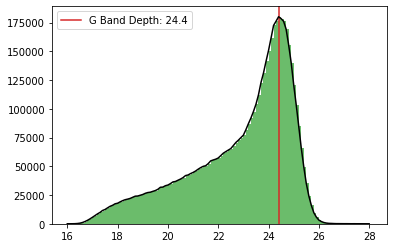

In [9]:
count = plt.hist(new_g, bins=np.arange(16, 28.1, 0.1), alpha=0.7, color='tab:green')
bins = count[1][:-1]
curve = count[0]
peaks = find_peaks(curve,threshold=50)
plt.axvline(bins[peaks[0][0]], color='tab:red', label='G Band Depth: '+str(np.round(bins[peaks[0][0]], 2)))
plt.plot(bins, curve, color='black')
plt.legend()
plt.show()

g_depth = bins[peaks[0][0]]

#Hyper-SUBPRIME

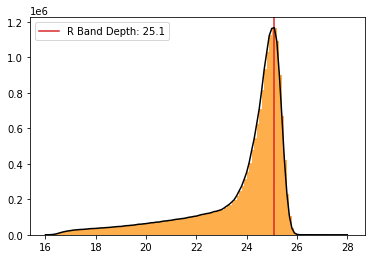

In [10]:
count = plt.hist(new_r, bins=np.arange(16, 28.1, 0.1), alpha=0.7, color='darkorange')
bins = count[1][:-1]
curve = count[0]
peaks = find_peaks(curve,height=100000)
plt.axvline(bins[peaks[0][0]], color='tab:red', label='R Band Depth: '+str(np.round(bins[peaks[0][0]], 2)))
plt.plot(bins, curve, color='black')
plt.legend()
plt.show()

r_depth = bins[peaks[0][0]]

#CFIS

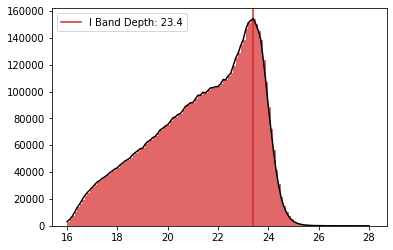

In [11]:
count = plt.hist(new_i, bins=np.arange(16, 28.1, 0.1), alpha=0.7, color='tab:red')
bins = count[1][:-1]
curve = count[0]
peaks = find_peaks(curve,height=100000, threshold=1000)
plt.axvline(bins[peaks[0][0]], color='tab:red', label='I Band Depth: '+str(np.round(bins[peaks[0][0]], 2)))
plt.plot(bins, curve, color='black')
plt.legend()
plt.show()

i_depth = bins[peaks[0][0]]

#Pan-STARRS

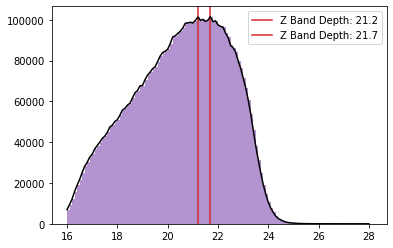

In [12]:
count = plt.hist(new_z, bins=np.arange(16, 28.1, 0.1), alpha=0.7, color='tab:purple')
bins = count[1][:-1]
curve = count[0]
peaks = find_peaks(curve,height=100000, threshold=1000)
plt.axvline(bins[peaks[0][0]], color='tab:red', label='Z Band Depth: '+str(np.round(bins[peaks[0][0]], 2)))
plt.axvline(bins[peaks[0][1]], color='tab:red', label='Z Band Depth: '+str(np.round(bins[peaks[0][1]], 2)))
plt.plot(bins, curve, color='black')
plt.legend()
plt.show()

z_depth = bins[peaks[0][0]], bins[peaks[0][1]]

#Pan-STARRS

### Error per magnitude in each band

np.polyfit is a least-squares polynomial fit. I am using a linear (degree 1) fit on log(err), mag space

In [13]:
from timeit import default_timer as timer
start = timer()
end = timer()
print(end - start)

4.4119000449427404e-05


In [14]:
valid_u = spec_cut(mag_or_err_cut(0, u_depth, new_u), [new_u, new_u_err])
uband_trust = valid_u[0]
uerr_trust = valid_u[1]

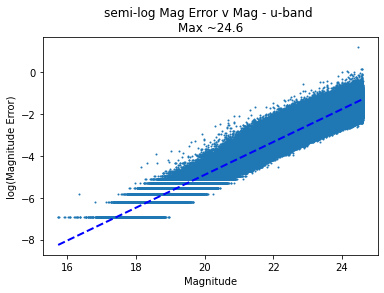

In [15]:
curve_fit = np.polyfit(uband_trust, ma.log(uerr_trust), 1)
u_m, u_b = curve_fit
x = np.arange(np.min(uband_trust), np.max(uband_trust), 0.01)

plt.scatter(uband_trust, ma.log(uerr_trust), s=1, c='tab:blue')
plt.plot(x, u_m*x+u_b, ls='--', lw=2, c='blue')

plt.xlabel('Magnitude')
plt.ylabel('log(Magnitude Error)')
plt.title('semi-log Mag Error v Mag - u-band \nMax ~'+str(np.round(u_depth, 2)))
plt.show()

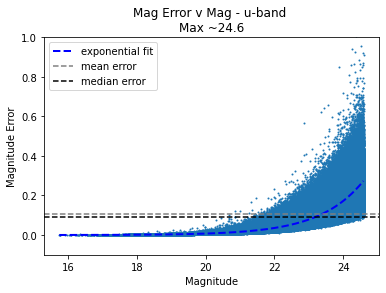

In [16]:
umean, umedian = np.round(np.mean(uerr_trust), 4), np.round(np.median(uerr_trust), 4)

plt.scatter(uband_trust, uerr_trust, s=1, color='tab:blue')
plt.plot(x, np.exp(u_b)*np.exp(u_m*x), c='blue', lw=2, ls='--', label='exponential fit')
plt.axhline(umean, color='grey', ls='--', label='mean error')
plt.axhline(umedian, color='black', ls='--', label='median error')

plt.ylim([-0.1, 1])
plt.xlabel('Magnitude')
plt.ylabel('Magnitude Error')
plt.title('Mag Error v Mag - u-band \nMax ~'+str(np.round(u_depth, 2)))
plt.legend()
plt.show()


time without mean+median = 26.67s
time with mean+median = 26.72s

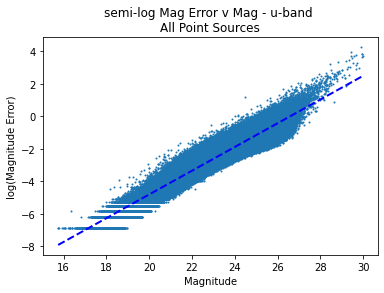

In [31]:
curve_fit = np.polyfit(new_u, ma.log(new_u_err), 1)
u_m, u_b = curve_fit
x = np.arange(np.min(new_u), np.max(new_u), 0.01)

plt.scatter(new_u, ma.log(new_u_err), s=1, c='tab:blue')
plt.plot(x, u_m*x+u_b, ls='--', lw=2, c='blue')

plt.xlabel('Magnitude')
plt.ylabel('log(Magnitude Error)')
plt.title('semi-log Mag Error v Mag - u-band \nAll Point Sources')
plt.show()

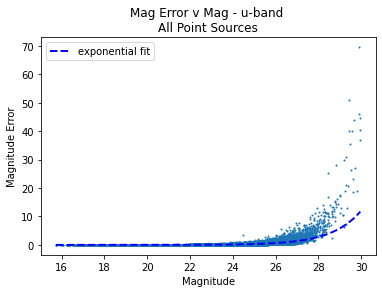

In [32]:
umean, umedian = np.round(np.mean(new_u), 4), np.round(np.median(new_u_err), 4)

plt.scatter(new_u, new_u_err, s=1, color='tab:blue')
plt.plot(x, np.exp(u_b)*np.exp(u_m*x), c='blue', lw=2, ls='--', label='exponential fit')
#plt.axhline(umean, color='grey', ls='--', label='mean error')
#plt.axhline(umedian, color='black', ls='--', label='median error')

#plt.ylim([-0.1, 1])
plt.xlabel('Magnitude')
plt.ylabel('Magnitude Error')
plt.title('Mag Error v Mag - u-band \nAll Point Sources')
plt.legend()
plt.show()

In [15]:
bins = np.arange(15, 31, 0.5)

In [47]:
temp_points = []
for i in range(1, len(bins)):
    temp_u, temp_err = spec_cut(mag_or_err_cut(bins[i-1], bins[i], new_u), [new_u, new_u_err])
    temp_pt = (bins[i-1]+bins[i])/2
    if len(temp_u)==0:
        temp_avg = np.nan
    else:
        temp_avg = np.mean(temp_err)
    temp_points.append(np.array([temp_pt, temp_avg]))
temp_points = np.array(temp_points)

(0.7695397245846339, -20.077214388002247)

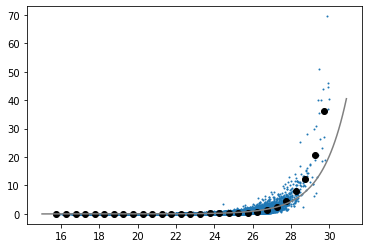

In [59]:
x = np.arange(15, 31, 0.1)
m, b = np.polyfit(temp_points.T[0][1:-1], ma.log(temp_points.T[1])[1:-1], 1)

plt.plot(x, np.exp(b)*np.exp(m*x), color='grey')
plt.scatter(new_u, new_u_err, s=1, color='tab:blue')
plt.scatter(temp_points.T[0], temp_points.T[1], color='black')
m, b

/Users/simonsmith/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/simonsmith/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


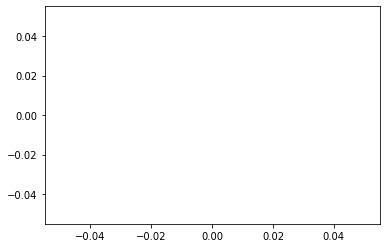

In [28]:
temp_pt = (bins[0]+bins[1])/2
temp_avg = np.mean(temp_err)
plt.scatter(temp_u, temp_err)
plt.axhline(temp_avg)
plt.plot(temp_pt, temp_avg, 'ro')

In [17]:
valid_g = spec_cut(mag_or_err_cut(0, g_depth, new_g), [new_g, new_g_err])
gband_trust = valid_g[0]
gerr_trust = valid_g[1]

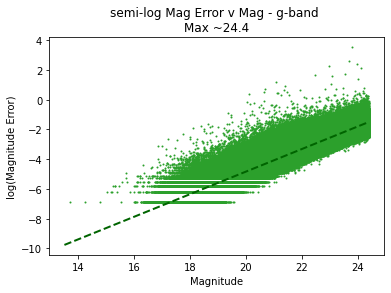

In [18]:
curve_fit = np.polyfit(gband_trust, ma.log(gerr_trust), 1)
g_m, g_b = curve_fit
x = np.arange(13.5, np.max(gband_trust), 0.01)

plt.scatter(gband_trust, ma.log(gerr_trust), s=1, c='tab:green')
plt.plot(x, g_m*x+g_b, ls='--', lw=2, c='darkgreen')

plt.xlabel('Magnitude')
plt.ylabel('log(Magnitude Error)')
plt.title('semi-log Mag Error v Mag - g-band \nMax ~'+str(np.round(g_depth, 2)))
plt.show()

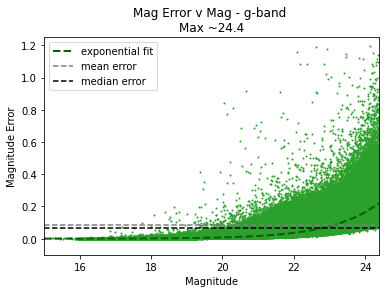

In [19]:
gmean, gmedian = np.round(np.mean(gerr_trust), 4), np.round(np.median(gerr_trust), 4)

plt.scatter(gband_trust, gerr_trust, s=1, color='tab:green')
plt.plot(x, np.exp(g_b)*np.exp(g_m*x), c='darkgreen', lw=2, ls='--', label='exponential fit')
plt.axhline(gmean, color='grey', ls='--', label='mean error')
plt.axhline(gmedian, color='black', ls='--', label='median error')

plt.xlim([15, np.max(x)])
plt.ylim([-0.1, 1.25])
plt.xlabel('Magnitude')
plt.ylabel('Magnitude Error')
plt.title('Mag Error v Mag - g-band \nMax ~'+str(np.round(g_depth, 2)))
plt.legend()
plt.show()

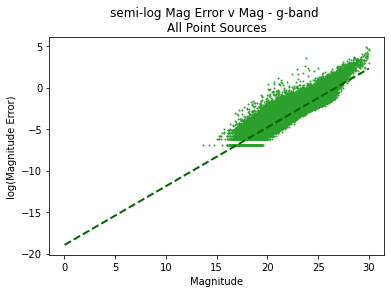

In [33]:
curve_fit = np.polyfit(new_g, ma.log(new_g_err), 1)
g_m, g_b = curve_fit
x = np.arange(np.min(new_g), np.max(new_g), 0.01)

plt.scatter(new_g, ma.log(new_g_err), s=1, c='tab:green')
plt.plot(x, g_m*x+g_b, ls='--', lw=2, c='darkgreen')

plt.xlabel('Magnitude')
plt.ylabel('log(Magnitude Error)')
plt.title('semi-log Mag Error v Mag - g-band \nAll Point Sources')
plt.show()

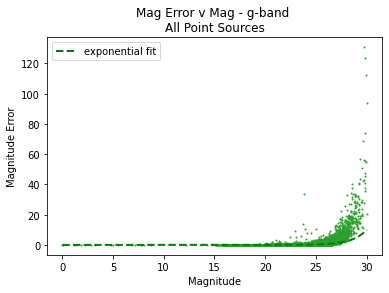

In [34]:
gmean, gmedian = np.round(np.mean(new_g), 4), np.round(np.median(new_g_err), 4)

plt.scatter(new_g, new_g_err, s=1, color='tab:green')
plt.plot(x, np.exp(g_b)*np.exp(g_m*x), c='green', lw=2, ls='--', label='exponential fit')
#plt.axhline(umean, color='grey', ls='--', label='mean error')
#plt.axhline(umedian, color='black', ls='--', label='median error')

#plt.ylim([-0.1, 1])
plt.xlabel('Magnitude')
plt.ylabel('Magnitude Error')
plt.title('Mag Error v Mag - g-band \nAll Point Sources')
plt.legend()
plt.show()

In [20]:
valid_r = spec_cut(mag_or_err_cut(0, r_depth, new_r), [new_r, new_r_err])
rband_trust = valid_r[0]
rerr_trust = valid_r[1]

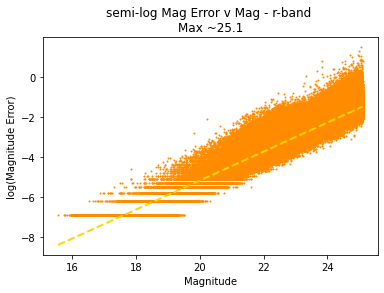

In [21]:
curve_fit = np.polyfit(rband_trust, ma.log(rerr_trust), 1)
r_m, r_b = curve_fit
x = np.arange(np.min(rband_trust), np.max(rband_trust), 0.01)

plt.scatter(rband_trust, ma.log(rerr_trust), s=1, c='darkorange')
plt.plot(x, r_m*x+r_b, ls='--', lw=2, c='gold')

plt.xlabel('Magnitude')
plt.ylabel('log(Magnitude Error)')
plt.title('semi-log Mag Error v Mag - r-band \nMax ~'+str(np.round(r_depth, 2)))
plt.show()

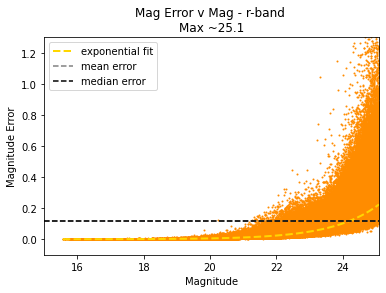

In [22]:
rmean, rmedian = np.round(np.mean(rerr_trust), 4), np.round(np.median(rerr_trust), 4)

plt.scatter(rband_trust, rerr_trust, s=1, color='darkorange')
plt.plot(x, np.exp(r_b)*np.exp(r_m*x), c='gold', lw=2, ls='--', label='exponential fit')
plt.axhline(rmean, color='grey', ls='--', label='mean error')
plt.axhline(rmedian, color='black', ls='--', label='median error')

plt.xlim([15, np.max(x)])
plt.ylim([-0.1, 1.3])
plt.xlabel('Magnitude')
plt.ylabel('Magnitude Error')
plt.title('Mag Error v Mag - r-band \nMax ~'+str(np.round(r_depth, 2)))
plt.legend()
plt.show()

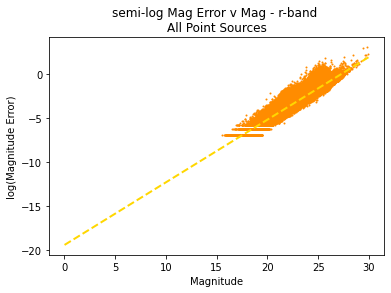

In [37]:
curve_fit = np.polyfit(new_r, ma.log(new_r_err), 1)
r_m, r_b = curve_fit
x = np.arange(np.min(new_g), np.max(new_g), 0.01)

plt.scatter(new_r, ma.log(new_r_err), s=1, c='darkorange')
plt.plot(x, r_m*x+r_b, ls='--', lw=2, c='gold')

plt.xlabel('Magnitude')
plt.ylabel('log(Magnitude Error)')
plt.title('semi-log Mag Error v Mag - r-band \nAll Point Sources')
plt.show()

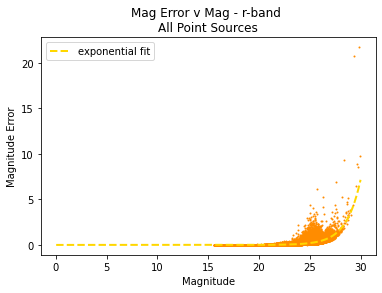

In [38]:
rmean, rmedian = np.round(np.mean(new_r), 4), np.round(np.median(new_r_err), 4)

plt.scatter(new_r, new_r_err, s=1, color='darkorange')
plt.plot(x, np.exp(r_b)*np.exp(r_m*x), c='gold', lw=2, ls='--', label='exponential fit')
#plt.axhline(umean, color='grey', ls='--', label='mean error')
#plt.axhline(umedian, color='black', ls='--', label='median error')

#plt.ylim([-0.1, 1])
plt.xlabel('Magnitude')
plt.ylabel('Magnitude Error')
plt.title('Mag Error v Mag - r-band \nAll Point Sources')
plt.legend()
plt.show()

In [23]:
valid_i = spec_cut(mag_or_err_cut(0, i_depth, new_i), [new_i, new_i_err])
iband_trust = valid_i[0]
ierr_trust = valid_i[1]

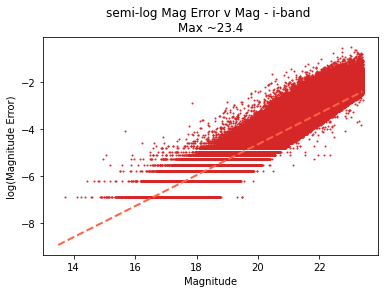

In [24]:
curve_fit = np.polyfit(iband_trust, ma.log(ierr_trust), 1)
i_m, i_b = curve_fit
x = np.arange(13.5, np.max(iband_trust), 0.01)

plt.scatter(iband_trust, ma.log(ierr_trust), s=1, c='tab:red')
plt.plot(x, i_m*x+i_b, ls='--', lw=2, c='tomato')

plt.xlabel('Magnitude')
plt.ylabel('log(Magnitude Error)')
plt.title('semi-log Mag Error v Mag - i-band \nMax ~'+str(np.round(i_depth, 2)))
plt.show()

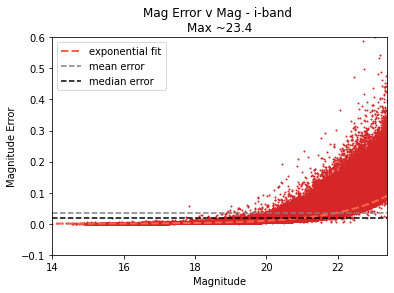

In [25]:
imean, imedian = np.round(np.mean(ierr_trust), 4), np.round(np.median(ierr_trust), 4)

plt.scatter(iband_trust, ierr_trust, s=1, color='tab:red')
plt.plot(x, np.exp(i_b)*np.exp(i_m*x), c='tomato', lw=2, ls='--', label='exponential fit')
plt.axhline(imean, color='grey', ls='--', label='mean error')
plt.axhline(imedian, color='black', ls='--', label='median error')

plt.xlim([14, np.max(x)])
plt.ylim([-0.1, 0.6])
plt.xlabel('Magnitude')
plt.ylabel('Magnitude Error')
plt.title('Mag Error v Mag - i-band \nMax ~'+str(np.round(i_depth, 2)))
plt.legend()
plt.show()

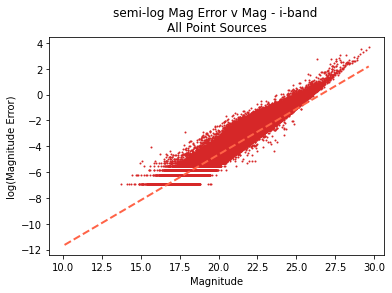

In [40]:
curve_fit = np.polyfit(new_i, ma.log(new_i_err), 1)
i_m, i_b = curve_fit
x = np.arange(np.min(new_i), np.max(new_i), 0.01)

plt.scatter(new_i, ma.log(new_i_err), s=1, c='tab:red')
plt.plot(x, i_m*x+i_b, ls='--', lw=2, c='tomato')

plt.xlabel('Magnitude')
plt.ylabel('log(Magnitude Error)')
plt.title('semi-log Mag Error v Mag - i-band \nAll Point Sources')
plt.show()

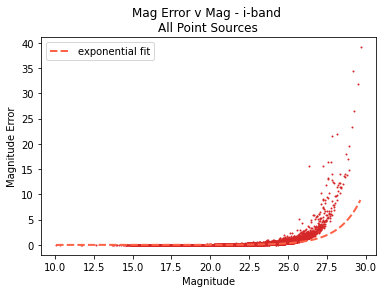

In [41]:
imean, imedian = np.round(np.mean(new_i), 4), np.round(np.median(new_i_err), 4)

plt.scatter(new_i, new_i_err, s=1, color='tab:red')
plt.plot(x, np.exp(i_b)*np.exp(i_m*x), c='tomato', lw=2, ls='--', label='exponential fit')
#plt.axhline(umean, color='grey', ls='--', label='mean error')
#plt.axhline(umedian, color='black', ls='--', label='median error')

#plt.ylim([-0.1, 1])
plt.xlabel('Magnitude')
plt.ylabel('Magnitude Error')
plt.title('Mag Error v Mag - i-band \nAll Point Sources')
plt.legend()
plt.show()

In [26]:
valid_z = spec_cut(mag_or_err_cut(0, z_depth[0], new_z), [new_z, new_z_err])
zband_trust = valid_z[0]
zerr_trust = valid_z[1]

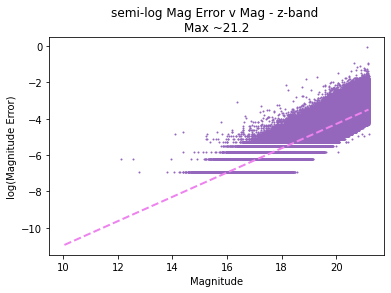

In [27]:
curve_fit = np.polyfit(zband_trust, ma.log(zerr_trust), 1)
z_m, z_b = curve_fit
x = np.arange(np.min(zband_trust), np.max(zband_trust), 0.01)

plt.scatter(zband_trust, ma.log(zerr_trust), s=1, c='tab:purple')
plt.plot(x, z_m*x+z_b, ls='--', lw=2, c='violet')

plt.xlabel('Magnitude')
plt.ylabel('log(Magnitude Error)')
plt.title('semi-log Mag Error v Mag - z-band \nMax ~'+str(np.round(z_depth[0], 2)))
plt.show()

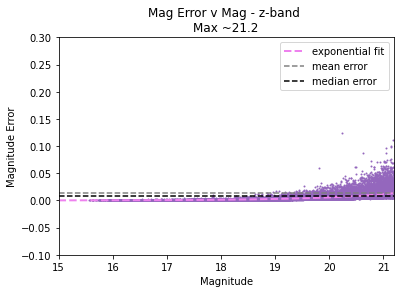

In [28]:
zmean, zmedian = np.round(np.mean(zerr_trust), 4), np.round(np.median(zerr_trust), 4)

plt.scatter(rband_trust, rerr_trust, s=1, color='tab:purple')
plt.plot(x, np.exp(r_b)*np.exp(r_m*x), c='violet', lw=2, ls='--', label='exponential fit')
plt.axhline(zmean, color='grey', ls='--', label='mean error')
plt.axhline(zmedian, color='black', ls='--', label='median error')

plt.xlim([15, np.max(x)])
plt.ylim([-0.1, 0.3])
plt.xlabel('Magnitude')
plt.ylabel('Magnitude Error')
plt.title('Mag Error v Mag - z-band \nMax ~'+str(np.round(z_depth[0], 2)))
plt.legend()
plt.show()

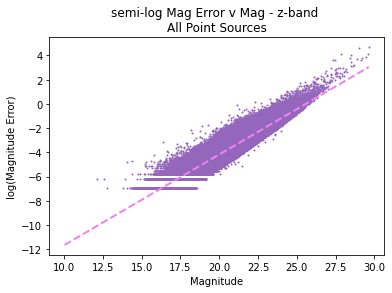

In [42]:
curve_fit = np.polyfit(new_z, ma.log(new_z_err), 1)
z_m, z_b = curve_fit
x = np.arange(np.min(new_z), np.max(new_z), 0.01)

plt.scatter(new_z, ma.log(new_z_err), s=1, c='tab:purple')
plt.plot(x, z_m*x+z_b, ls='--', lw=2, c='violet')

plt.xlabel('Magnitude')
plt.ylabel('log(Magnitude Error)')
plt.title('semi-log Mag Error v Mag - z-band \nAll Point Sources')
plt.show()

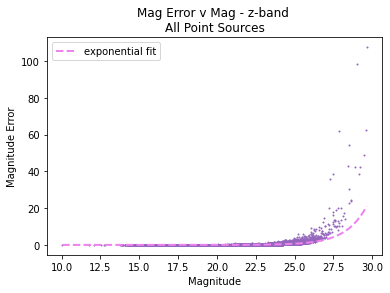

In [43]:
zmean, zmedian = np.round(np.mean(new_z), 4), np.round(np.median(new_z_err), 4)

plt.scatter(new_z, new_z_err, s=1, color='tab:purple')
plt.plot(x, np.exp(z_b)*np.exp(z_m*x), c='violet', lw=2, ls='--', label='exponential fit')
#plt.axhline(umean, color='grey', ls='--', label='mean error')
#plt.axhline(umedian, color='black', ls='--', label='median error')

#plt.ylim([-0.1, 1])
plt.xlabel('Magnitude')
plt.ylabel('Magnitude Error')
plt.title('Mag Error v Mag - z-band \nAll Point Sources')
plt.legend()
plt.show()

In [ ]:
#Consider instead binning the data using my cut function, finding mean, median in each bin 
#with some decent bin resolution. Fit that with an exponential